# Airbnb Popularity Predict

In the second part, we will illustrate the use of multiple linear regression for finding the effect of important factors affecting the sale of Airbnb hosting.
The data for the  is taken generously from Kaggle's [New York City Airbnb Open Data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data).
For the second part, we will focus on the task of predicting the popularity of airbnb listing, which is indicated by the number of reviews from the dataset:

<img src="airbnb.png" height="300" width="300">


The factors we will be taking into considerations for the second part are: neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, availability_365.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.metrics.pairwise import pairwise_kernels
import scipy
from sklearn import svm, linear_model
from sklearn.model_selection import GridSearchCV
import time
import seaborn as sns

In [26]:
df = pd.read_csv('AB_NYC_2019.csv',
                na_values='?',header=None)
df.columns = df.iloc[0]
df = df[1:]
df = df.dropna()
df.head()

C:\Users\zzw_e\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,6,7,9,10,11,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
4,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
6,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.975,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# Preprocess Data

In [27]:
xnames = ['neighbourhood_group','neighbourhood','latitude','longitude','room_type','price',
         'minimum_nights', 'calculated_host_listings_count','availability_365']
X = np.array(df[xnames])
ID = np.array(df['id'])
ID = ID.astype(int)
y = np.array(df['reviews_per_month'])
y = y.astype(float)
# Convert neighborhood to ascii code
neighbourhood_group = X[:,0]
for i in range(len(neighbourhood_group)):
    new = sum(ord(c) for c in neighbourhood_group[i])
    neighbourhood_group[i] = int(new)

# convert neighborhood to ascii code
neighbourhood = X[:,1]
for i in range(len(neighbourhood)):
    new = sum(ord(c) for c in neighbourhood[i])
    neighbourhood[i] = int(new)

# Convert room_type: Private room-0, Entire home/apt-1
room_type = X[:,4]
PRI_VAL = "Private room"
ENT_VAL = "Entire home/apt"
for i in range(len(room_type)):
    if room_type[i] == PRI_VAL:
        room_type[i] = 0
    elif room_type[i] == ENT_VAL:
        room_type[i] = 1
    else:
        room_type[i] = 2
X[:,2] = X[:,2].astype(float)
X[:,3] = X[:,3].astype(float)
X[:,5] = X[:,5].astype(int)
X[:,6] = X[:,6].astype(int)
X[:,7] = X[:,7].astype(int)
X[:,8] = X[:,8].astype(int)
print("Converted Dataset X:\n",X)
print("\nwith dimension:\n", X.shape)
df["room_type"] = room_type
df["neighbourhood_group"] = neighbourhood_group
df["neighbourhood"] = neighbourhood

Converted Dataset X:
 [[848 1056 40.64749 ... 1 6 365]
 [924 738 40.75362 ... 1 2 355]
 [848 1152 40.68514 ... 1 1 194]
 ...
 [1258 1042 40.54179 ... 1 1 87]
 [521 950 40.80787 ... 1 1 40]
 [848 832 40.69805 ... 1 1 1]]

with dimension:
 (38821, 9)


In [28]:
df["reviews_per_month"].describe()

count     38821
unique     1626
top        0.02
freq        914
Name: reviews_per_month, dtype: object

In [29]:
sns.set()
df["room_type"] = df["room_type"].astype(int)
df["neighbourhood_group"] = df["neighbourhood_group"].astype(int)
df["neighbourhood"] = df["neighbourhood"].astype(int)
df['reviews_per_month'] = df['reviews_per_month'].astype(float)
df['price'] = df['price'].astype(int)
df["calculated_host_listings_count"] = df["calculated_host_listings_count"].astype(int)
df['minimum_nights'] = df['minimum_nights'].astype(int)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['availability_365'] = df['availability_365'].astype(int)
input_lst = ['neighbourhood_group','neighborhood','latitude','longitude','room_type','price',
         'minimum_nights', 'calculated_host_listings_count','availability_365','number_of_reviews']

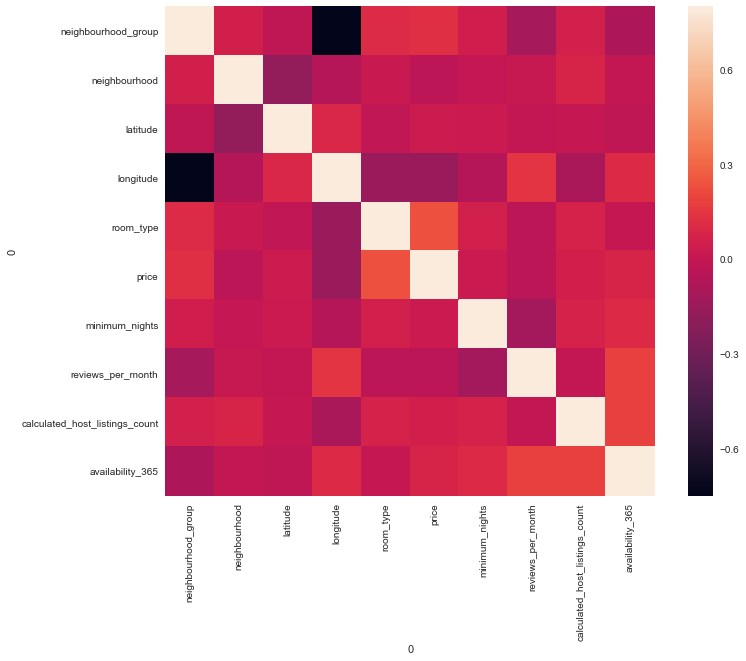

In [30]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

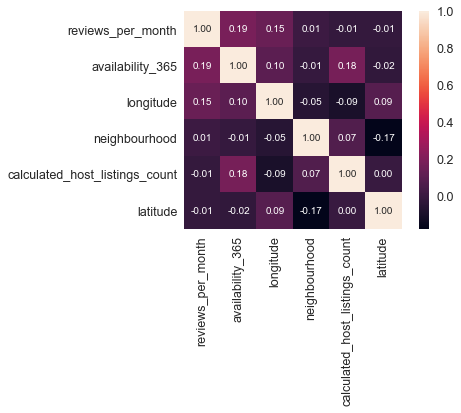

In [31]:
#saleprice correlation matrix
k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'reviews_per_month')['reviews_per_month'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Split data into a training and test set with a ratio of 2/3 - 1/3

In [32]:
nt = len(X)
ind_lst = np.random.permutation(nt)

ntr = len(ind_lst) * 2//3
ntr_lst = ind_lst[:ntr]
nts = len(ind_lst) - ntr
nts_lst = ind_lst[ntr:]

IDtr = ID[ntr_lst]
IDts = ID[nts_lst]

Xtr = np.matrix(X[[ntr_lst]], dtype='int')
Xts1 = np.matrix(X[[nts_lst]], dtype='int')
ytr = y[ntr_lst]
yts1 = y[nts_lst]
print("X training set:\n",Xtr)
print("\nX testing set:\n",Xts1)
print("\ny training set:\n",ytr)
print("\ny testing set:\n",yts1)

X training set:
 [[ 625  723   40 ...    4    1  170]
 [ 848 1051   40 ...    1    1  255]
 [ 848 1269   40 ...    4    1    0]
 ...
 [ 848 1041   40 ...    3    3    0]
 [ 848 1072   40 ...    4    1    3]
 [ 924  601   40 ...    7    3  193]]

X testing set:
 [[ 848  832   40 ...    2    1  288]
 [ 848 1833   40 ...    1    2   68]
 [ 924 1771   40 ...    2    1  246]
 ...
 [ 924  723   40 ...    2    3  345]
 [ 625  939   40 ...    2    1  174]
 [ 848 1266   40 ...    1    2   64]]

y training set:
 [0.82 4.97 0.1  ... 0.41 0.18 0.99]

y testing set:
 [2.21 0.47 2.74 ... 1.   2.   1.63]


# Fit a Multi-Linear Model

In [33]:
def fit_mult_linear(X,y):
    """
    Given matrix of predictors X and target vector y fit for a multiple linear regression model under the squared loss.
    """
    nsamp = len(X)
    ones = np.ones((nsamp,1))
    X_orig = X
    X = np.hstack((ones,X_orig))
    Xmat=np.matrix(X)
    ymat=np.matrix(y)
    ymat=np.transpose(ymat)
    Xmatt=np.transpose(Xmat)
    beta=np.linalg.inv(Xmatt*Xmat)*Xmatt*ymat
    return beta

In [34]:
beta_lst = fit_mult_linear(Xtr, ytr)
beta0 = beta_lst[0]
beta1 = beta_lst[1:]
print("beta_lst:\n",beta_lst)
print("beta0:\n",beta0)
print("beta1:\n",beta1)

beta_lst:
 [[ 3.90678075e+16]
 [ 4.61799502e-01]
 [ 1.73604857e-02]
 [-6.64554092e+14]
 [ 1.62829064e+01]
 [-2.24693841e+01]
 [ 4.64902790e-03]
 [-4.01970871e-02]
 [-3.60004647e-03]
 [ 9.46022869e-03]]
beta0:
 [[3.90678075e+16]]
beta1:
 [[ 4.61799502e-01]
 [ 1.73604857e-02]
 [-6.64554092e+14]
 [ 1.62829064e+01]
 [-2.24693841e+01]
 [ 4.64902790e-03]
 [-4.01970871e-02]
 [-3.60004647e-03]
 [ 9.46022869e-03]]


In [35]:
nsamp = len(Xtr)
ones = np.ones((nsamp,1))
X_orig = Xtr
X = np.hstack((ones,X_orig))
Xmat=np.matrix(X)
ymat=np.matrix(ytr)
ymat=np.transpose(ymat)

ytr_pred = Xmat*beta_lst
lossm = np.linalg.norm(np.array(ymat - ytr_pred))**2

print("multiple variable loss="+"{:.2e}".format(lossm))

multiple variable loss=4.03e+36


# Measure the Fit on the Testing Dataset

In [12]:
beta_ts = fit_mult_linear(Xts1, yts1)
beta0_ts = beta_ts[0]
beta1_ts = beta_ts[1:]
print("beta_test:\n",beta_ts)
print("beta0_test:\n",beta0_ts)
print("beta1_test:\n",beta1_ts)

beta_test:
 [[-2.61807188e+01]
 [-1.24522195e-03]
 [ 7.97357960e-05]
 [ 6.42231025e-01]
 [-5.89739847e-02]
 [-3.49015406e-02]
 [-2.63878543e-04]
 [-1.48370369e-02]
 [-2.04149817e-03]
 [ 2.50168659e-03]]
beta0_test:
 [[-26.18071881]]
beta1_test:
 [[-1.24522195e-03]
 [ 7.97357960e-05]
 [ 6.42231025e-01]
 [-5.89739847e-02]
 [-3.49015406e-02]
 [-2.63878543e-04]
 [-1.48370369e-02]
 [-2.04149817e-03]
 [ 2.50168659e-03]]


In [13]:
nsamp_test = len(Xts1)
ones_test = np.ones((nsamp_test,1))
X_orig_test = Xts1
X_test = np.hstack((ones_test,X_orig_test))
Xmat_test=np.matrix(X_test)
ymat_test=np.matrix(yts1)
ymat_test=np.transpose(ymat_test)

ytrain_pred_test = Xmat_test*beta_ts
lossm_test = np.linalg.norm(np.array(ymat_test - ytrain_pred_test))**2
print("multiple variable loss="+"{:.2e}".format(lossm_test))

multiple variable loss=6.72e+04


# Fit Data on Keras Model

In [14]:
df_tr = pd.read_csv('AB_NYC_2019.csv',
                na_values='?',header=None)
df_tr.columns = df_tr.iloc[0]
df_tr = df_tr[1:]
df_tr = df_tr.dropna()

C:\Users\zzw_e\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,6,7,9,10,11,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
inputs = ['neighbourhood_group','neighbourhood','latitude','longitude','room_type','price',
         'minimum_nights', 'calculated_host_listings_count','availability_365']
Xtr = df[inputs]
scale = StandardScaler()
Xtr = scale.fit_transform(Xtr)
y = df['reviews_per_month'].values
seed = 7
np.random.seed(seed)
Xtr, Xts, ytr, yts = train_test_split(Xtr, y, test_size=0.33, random_state=seed)
print('Xtr:\n',Xtr)

Xtr:
 [[-0.0202034  -0.65285978 -1.81540401 ... -0.10749563 -0.00633438
   1.93095823]
 [-2.04794151 -0.88019444  0.57957548 ... -0.22251218 -0.04435342
   1.53722182]
 [-0.0202034  -0.89807469 -1.40733006 ... -0.1650039  -0.15841052
  -0.88695918]
 ...
 [ 0.67086429  0.27691341  0.51465463 ...  0.06502919 -0.15841052
   1.63758601]
 [-0.0202034  -0.88019444 -0.79631023 ... -0.1650039  -0.15841052
   1.65302665]
 [-0.0202034   0.21050104 -1.99179962 ... -0.1650039  -0.15841052
   1.35965443]]


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

C:\Users\zzw_e\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Create Keras Model

In [18]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=Xtr.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_error', 
              metrics =[metrics.mae])
    return model

In [19]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
_________________________________________________________________


In [20]:
hist = model.fit(Xtr, ytr, validation_data=(Xts,yts), epochs=150, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 26010 samples, validate on 12811 samples
Epoch 1/150
26010/26010 [==============================] - 2s 59us/step - loss: 2.7111 - mean_absolute_error: 1.1265 - val_loss: 2.0976 - val_mean_absolute_error: 1.0404
Epoch 2/150
26010/26010 [==============================] - 1s 45us/step - loss: 2.2864 - mean_absolute_error: 1.0144 - val_loss: 2.0165 - val_mean_absolute_error: 0.9782
Epoch 3/150
26010/26010 [==============================] - 1s 45us/step - loss: 2.2234 - mean_absolute_error: 0.9929 - val_loss: 1.9589 - val_mean_absolute_error: 1.0052
Epoch 4/150
26010/26010 [==============================] - 1s 52us/step - loss: 2.1870 - mean_absolute_error: 0.9831 - val_loss: 1.9181 - val_mean_absolute_error: 0.9528
Epoch 5/150
26010/26010 [==============================] - 1s 55us/step - loss: 2.1609 - mean_absolute_error: 0.9733 - val_loss: 1.9356 - val_mean_absolute_error: 1.0036
Epoch 6/150
26010/26010 [===========================

26010/26010 [==============================] - 1s 45us/step - loss: 1.9266 - mean_absolute_error: 0.9100 - val_loss: 1.7904 - val_mean_absolute_error: 0.9170
Epoch 48/150
26010/26010 [==============================] - 1s 43us/step - loss: 1.9242 - mean_absolute_error: 0.9111 - val_loss: 1.7944 - val_mean_absolute_error: 0.9227
Epoch 49/150
26010/26010 [==============================] - 1s 45us/step - loss: 1.9211 - mean_absolute_error: 0.9096 - val_loss: 1.8013 - val_mean_absolute_error: 0.8764
Epoch 50/150
26010/26010 [==============================] - 1s 45us/step - loss: 1.9217 - mean_absolute_error: 0.9097 - val_loss: 1.7969 - val_mean_absolute_error: 0.9299
Epoch 51/150
26010/26010 [==============================] - 1s 45us/step - loss: 1.9116 - mean_absolute_error: 0.9080 - val_loss: 1.7690 - val_mean_absolute_error: 0.8976
Epoch 52/150
26010/26010 [==============================] - 1s 45us/step - loss: 1.9063 - mean_absolute_error: 0.9066 - val_loss: 1.7698 - val_mean_absolute_e

Epoch 95/150
26010/26010 [==============================] - 1s 45us/step - loss: 1.8581 - mean_absolute_error: 0.8954 - val_loss: 1.7640 - val_mean_absolute_error: 0.8890
Epoch 96/150
26010/26010 [==============================] - 1s 44us/step - loss: 1.8562 - mean_absolute_error: 0.8956 - val_loss: 1.7631 - val_mean_absolute_error: 0.9155
Epoch 97/150
26010/26010 [==============================] - 1s 49us/step - loss: 1.8510 - mean_absolute_error: 0.8945 - val_loss: 1.7840 - val_mean_absolute_error: 0.8809
Epoch 98/150
26010/26010 [==============================] - 1s 53us/step - loss: 1.8498 - mean_absolute_error: 0.8949 - val_loss: 1.8139 - val_mean_absolute_error: 0.9000
Epoch 99/150
26010/26010 [==============================] - 1s 44us/step - loss: 1.8525 - mean_absolute_error: 0.8962 - val_loss: 1.7929 - val_mean_absolute_error: 0.8805
Epoch 100/150
26010/26010 [==============================] - 1s 45us/step - loss: 1.8462 - mean_absolute_error: 0.8952 - val_loss: 1.7693 - val_m

Epoch 143/150
26010/26010 [==============================] - 1s 45us/step - loss: 1.8097 - mean_absolute_error: 0.8869 - val_loss: 1.8085 - val_mean_absolute_error: 0.9114
Epoch 144/150
26010/26010 [==============================] - 1s 45us/step - loss: 1.8085 - mean_absolute_error: 0.8874 - val_loss: 1.8067 - val_mean_absolute_error: 0.9459
Epoch 145/150
26010/26010 [==============================] - 1s 44us/step - loss: 1.8110 - mean_absolute_error: 0.8862 - val_loss: 1.7667 - val_mean_absolute_error: 0.9052
Epoch 146/150
26010/26010 [==============================] - 1s 45us/step - loss: 1.8094 - mean_absolute_error: 0.8871 - val_loss: 1.7880 - val_mean_absolute_error: 0.9023
Epoch 147/150
26010/26010 [==============================] - 1s 43us/step - loss: 1.8063 - mean_absolute_error: 0.8862 - val_loss: 1.7703 - val_mean_absolute_error: 0.8879
Epoch 148/150
26010/26010 [==============================] - 1s 44us/step - loss: 1.8080 - mean_absolute_error: 0.8867 - val_loss: 1.7916 - 

## Evaluation Model Performence

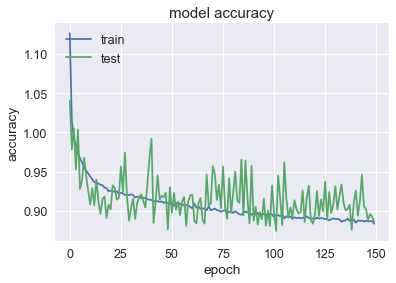

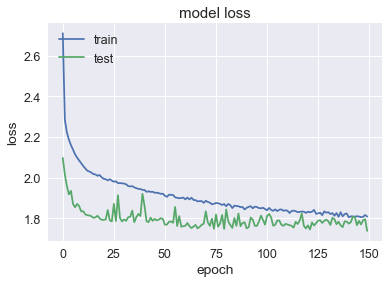

In [21]:
# Accuracy summary of Keras Model
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss summary of Keras Model
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Make Prediction on Testing Set

In [22]:
prediction = model.predict(Xts)
Xts_new = scale.inverse_transform(Xts)
result = {}
for i in range(len(inputs)):
    result[inputs[i]] = Xts_new[:,i]
result['reviews_per_month'] = prediction[:,0]

In [23]:
pd.DataFrame(result)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,reviews_per_month
0,848.0,1056.0,40.63581,-73.96977,0.0,40.0,2.0,1.0,6.0,1.135972
1,848.0,1269.0,40.67809,-73.95903,0.0,62.0,4.0,1.0,0.0,0.323979
2,924.0,738.0,40.75649,-73.97126,1.0,160.0,4.0,1.0,0.0,0.191492
3,924.0,693.0,40.75229,-73.99550,1.0,250.0,2.0,1.0,0.0,0.198700
4,848.0,1328.0,40.58198,-73.95770,0.0,35.0,1.0,5.0,186.0,2.223975
5,924.0,738.0,40.75417,-73.96557,1.0,737.0,3.0,49.0,188.0,0.735420
6,848.0,1254.0,40.65129,-73.94058,0.0,90.0,1.0,1.0,365.0,2.037304
7,848.0,1833.0,40.68382,-73.95566,1.0,300.0,2.0,1.0,0.0,0.354654
8,848.0,1833.0,40.69182,-73.92859,0.0,52.0,2.0,8.0,268.0,3.054527
9,924.0,1065.0,40.74915,-73.97610,1.0,220.0,30.0,1.0,310.0,0.838975
